https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations

In [1]:
from itertools import combinations
from collections import Counter

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


pd.set_option('display.max_columns', None)

## Transactions

In [2]:
transactions = pd.read_csv(r'./data/transactions_train.csv.zip')
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [3]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [4]:
transactions.t_dat = pd.to_datetime(transactions.t_dat)

In [5]:
transactions.isna().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

In [6]:
transactions.nunique()

t_dat                   734
customer_id         1362281
article_id           104547
price                  9857
sales_channel_id          2
dtype: int64

In [7]:
transactions[transactions.duplicated()].shape

(2974905, 5)

In [8]:
transactions.sales_channel_id.value_counts()

sales_channel_id
2    22379862
1     9408462
Name: count, dtype: int64

Посмотрим на распределение покупок товаров

Text(0.5, 1.0, 'sales_channel=2')

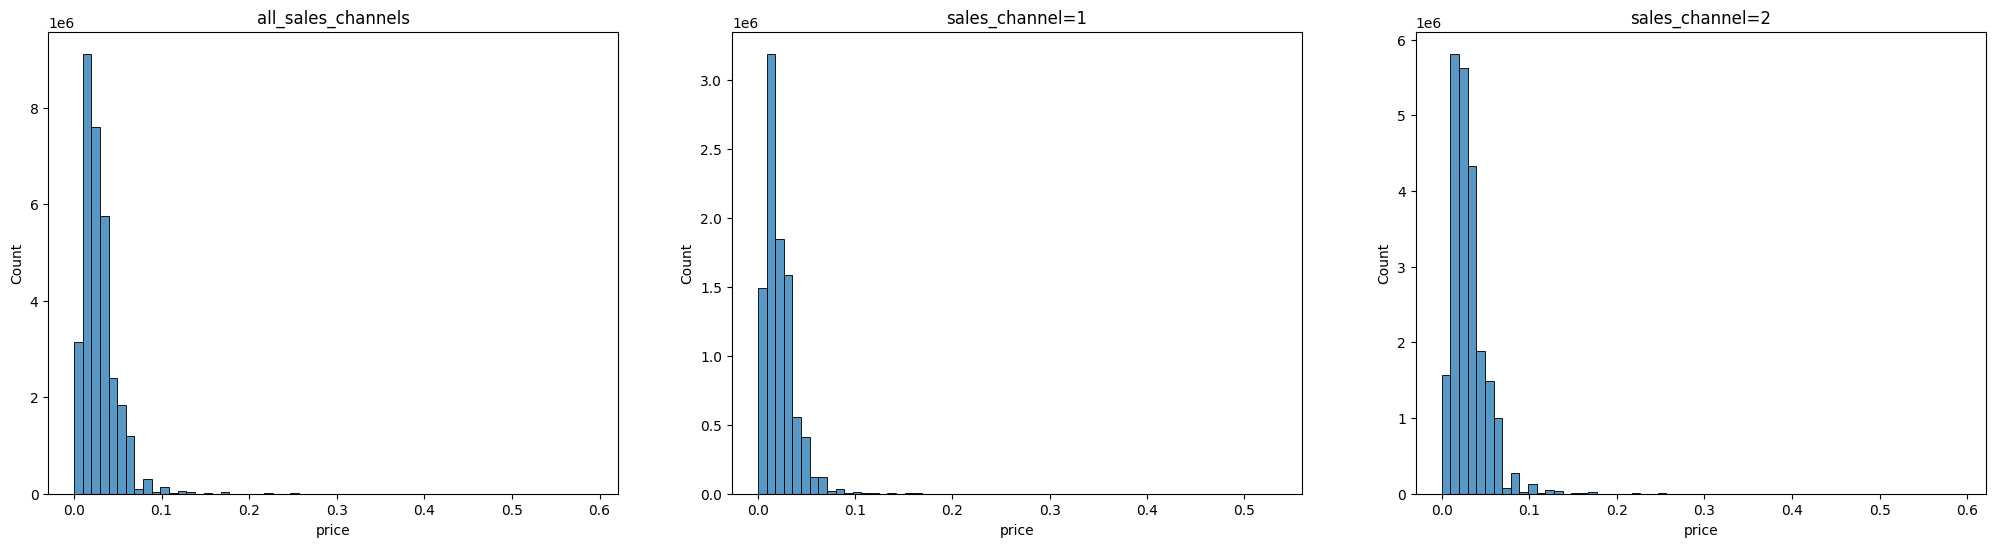

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))


sns.histplot(data=transactions, x='price', bins=60, ax=ax[0])
ax[0].set_title('all_sales_channels')
sns.histplot(data=transactions[transactions.sales_channel_id==1], x='price', bins=60, ax=ax[1])
ax[1].set_title('sales_channel=1')
sns.histplot(data=transactions[transactions.sales_channel_id==2], x='price', bins=60, ax=ax[2])
ax[2].set_title('sales_channel=2')

In [10]:
transactions['year_month'] = transactions.t_dat.dt.strftime('%Y-%m')
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,year_month
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,2018-09
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,2018-09
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,2018-09
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,2018-09
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,2018-09


Посмотрим на динамику покупок и кол-ва уникальных пользователей, сделавших покупку в этот день/месяц

In [11]:
fig = make_subplots(rows=2, cols=1, subplot_titles=('by_date', 'by_month'))

tmp = transactions \
    .groupby(['t_dat'], as_index=False) \
    .agg(purchases_count=('customer_id', pd.Series.count))

fig.add_trace(
    go.Scatter(x=tmp.t_dat, y=tmp.purchases_count, name='purchases'),
    row=1, col=1, 
)

tmp = transactions \
    .groupby('t_dat', as_index=False) \
    .agg(unique_users=('customer_id', pd.Series.nunique))

fig.add_trace(
    go.Scatter(x=tmp.t_dat, y=tmp.unique_users, name='unique_users'),
    row=1, col=1
)

tmp = transactions \
    .groupby(['year_month'], as_index=False) \
    .agg(purchases_count=('customer_id', pd.Series.count))

fig.add_trace(
    go.Scatter(x=tmp.year_month, y=tmp.purchases_count, name='purchases'),
    row=2, col=1
)

tmp = transactions \
    .groupby('year_month', as_index=False) \
    .agg(unique_users=('customer_id', pd.Series.nunique))

fig.add_trace(
    go.Scatter(x=tmp.year_month, y=tmp.unique_users, name='unique_users'),
    row=2, col=1
)

fig.update_layout(height=800)
fig.show()

Кол-во дней между покупками пользователя:

Text(0.5, 1.0, 'Days Between Orders')

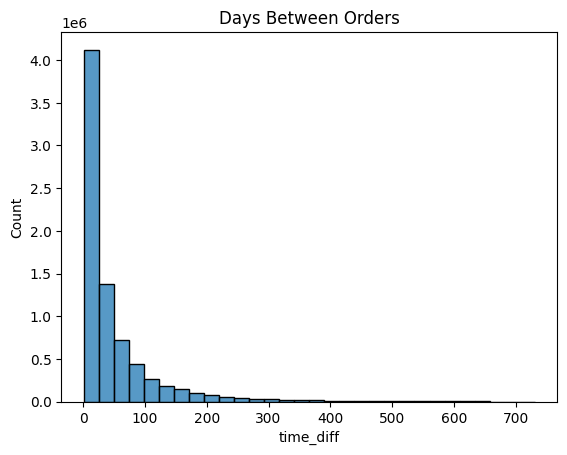

In [12]:
tmp = transactions.loc[:, ['customer_id', 't_dat']].sort_values(['customer_id', 't_dat'])
tmp['time_diff'] = (tmp.t_dat - tmp.groupby(['customer_id'], as_index=False).t_dat.shift(1)).dt.days
tmp = tmp[tmp.time_diff > 0]

sns.histplot(data=tmp, x='time_diff', bins=30)
plt.title('Days Between Orders')

Распределение стоимости конзины и кол-во товаров в корзине.

<Axes: xlabel='order_items', ylabel='Count'>

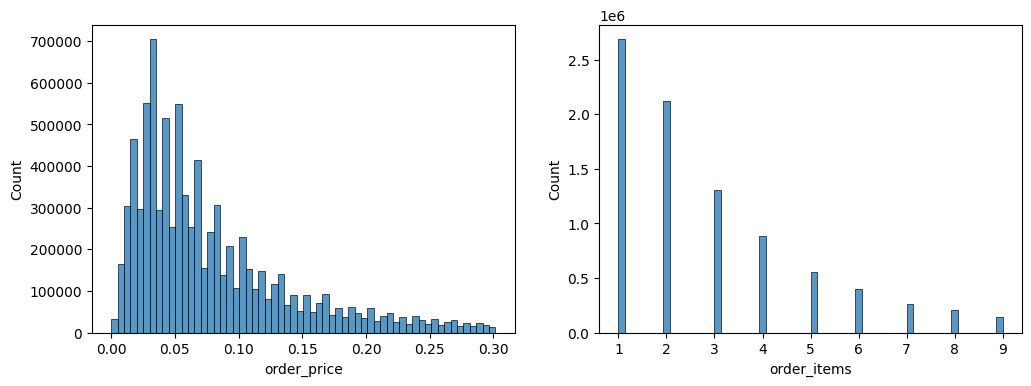

In [ ]:
tmp = transactions \
    .groupby(['customer_id', 't_dat'], as_index=False) \
    .agg(
        order_price=('price', pd.Series.sum),
        order_items=('price', pd.Series.count)
    )

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=tmp[tmp.order_price < tmp.order_price.quantile(0.95)], x='order_price', bins=60, ax=ax[0])
sns.histplot(data=tmp[tmp.order_items < tmp.order_items.quantile(0.95)], x='order_items', bins=60, ax=ax[1])

Таблицы на будущее:

In [14]:
user_actions = transactions \
    .groupby(['customer_id'], as_index=False) \
    .agg(
        first_purchase=('t_dat', pd.Series.min),
        last_purchase=('t_dat', pd.Series.max),
        user_purchases_count=('t_dat', pd.Series.count),
        user_total_check=('price', pd.Series.sum)
    )
user_actions.head()

,customer_id,first_purchase,last_purchase,user_purchases_count,user_total_check
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2018-12-27,2020-09-05,21,0.648983
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2018-09-21,2020-07-08,86,2.601932
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,2020-09-15,18,0.704780
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2019-06-09,2019-06-09,2,0.060983
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2018-10-12,2020-08-12,13,0.469695


In [ ]:
articles_purchases = transactions \
    .groupby(['article_id'], as_index=False) \
    .agg(
        first_purchase=('t_dat', pd.Series.min),
        last_purchase=('t_dat', pd.Series.max),
        purchases=('customer_id', pd.Series.count),
        revenue=('price', pd.Series.sum)
    )

articles_purchases

,article_id,first_purchase,last_purchase,purchases,revenue,lifetime
0,108775015,2018-09-20,2020-07-22,10841,88.262881,671
1,108775044,2018-09-20,2020-09-20,7250,58.826169,731
2,108775051,2018-09-20,2019-06-28,215,1.070644,281
3,110065001,2018-09-20,2020-08-02,1044,21.108746,682
4,110065002,2018-09-20,2020-08-05,539,9.812746,685
...,...,...,...,...,...,...
104542,952267001,2020-08-29,2020-09-22,41,0.614254,24
104543,952938001,2020-09-15,2020-09-22,9,0.432051,7
104544,953450001,2020-09-07,2020-09-22,17,0.286220,15
104545,953763001,2020-09-11,2020-09-22,35,0.766780,11


## Customers

In [16]:
customers = pd.read_csv(r'./data/customers.csv.zip')
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [17]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355969 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [18]:
customers.nunique()

customer_id               1371980
FN                              1
Active                          1
club_member_status              3
fashion_news_frequency          3
age                            84
postal_code                352899
dtype: int64

In [19]:
customers.club_member_status.unique()

array(['ACTIVE', nan, 'PRE-CREATE', 'LEFT CLUB'], dtype=object)

In [20]:
customers.isna().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16011
age                        15861
postal_code                    0
dtype: int64

In [21]:
customers.age.fillna(-1, inplace=True)
customers.fillna(0, inplace=True)
customers.loc[customers.fashion_news_frequency == 'NONE', 'fashion_news_frequency'] = 0

C:\Users\Shull\AppData\Local\Temp\ipykernel_14476\2296316239.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [22]:
customers[['FN', 'age', 'Active']] = customers[['FN', 'age', 'Active']].astype(int)

In [23]:
bins = [-np.inf, 0, 18, 30, 50, 100]
labels = ['unknown'] + [f'[{bins[i]}, {bins[i+1]})' for i in range(1, len(bins)-1)]

customers['age_group'] = pd.cut(customers['age'], bins=bins, labels=labels, right=False)
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,ACTIVE,0,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,"[30, 50)"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,ACTIVE,0,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,"[18, 30)"
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,ACTIVE,0,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"[18, 30)"
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,ACTIVE,0,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,"[50, 100)"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,"[50, 100)"


<Axes: xlabel='count', ylabel='club_member_status'>

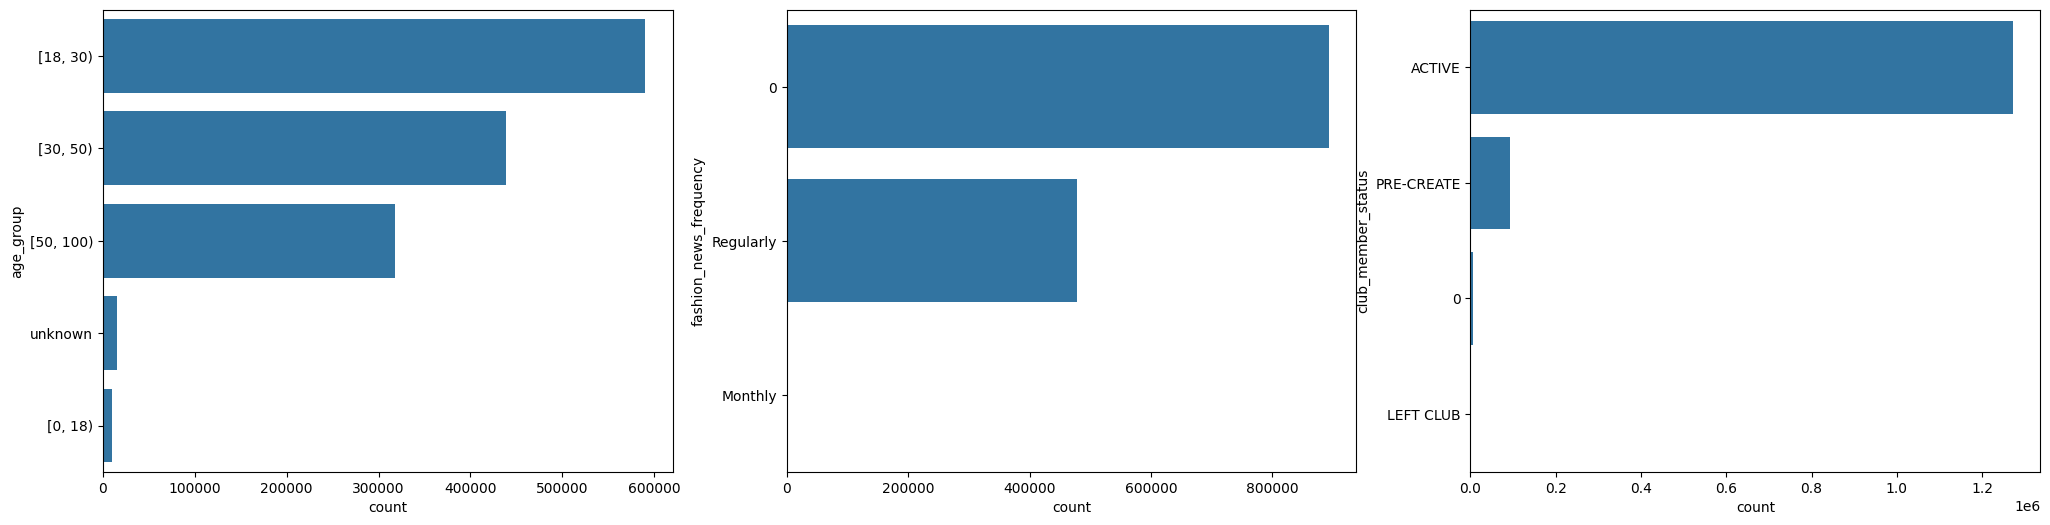

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))

sns.countplot(customers.age_group, order=customers['age_group'].value_counts().index, ax=ax[0])
sns.countplot(customers.fashion_news_frequency, order=customers['fashion_news_frequency'].value_counts().index, ax=ax[1])
sns.countplot(customers.club_member_status, order=customers['club_member_status'].value_counts().index, ax=ax[2])

Подписка на новостную рассылку в зависимости от возраста в процентах.

In [25]:
pivot = pd.pivot_table(customers, index='age_group', columns='fashion_news_frequency', values='customer_id', aggfunc='count', observed=True, fill_value=0)

(pivot.div(pivot.sum(axis=1), axis=0)*100).round()

fashion_news_frequency,0,Monthly,Regularly
age_group,,,
unknown,92.0,0.0,8.0
"[0, 18)",68.0,0.0,32.0
"[18, 30)",66.0,0.0,34.0
"[30, 50)",66.0,0.0,34.0
"[50, 100)",61.0,0.0,39.0


In [26]:
pivot = pd.pivot_table(customers, index='age_group', columns='club_member_status', values='customer_id', aggfunc='count', observed=True, fill_value=0)

(pivot.div(pivot.sum(axis=1), axis=0)*100).round()

club_member_status,0,ACTIVE,LEFT CLUB,PRE-CREATE
age_group,,,,
unknown,14.0,39.0,0.0,46.0
"[0, 18)",0.0,99.0,0.0,1.0
"[18, 30)",0.0,96.0,0.0,4.0
"[30, 50)",0.0,92.0,0.0,8.0
"[50, 100)",0.0,91.0,0.0,8.0


In [27]:
del pivot

In [28]:
# inner, потому что тут не интересны пользователи, не совершившие ни одной покупки.
paying_users = pd.merge(customers, user_actions, on='customer_id', how='inner')
del user_actions

In [29]:
paying_users.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_group,first_purchase,last_purchase,user_purchases_count,user_total_check
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,ACTIVE,0,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,"[30, 50)",2018-12-27,2020-09-05,21,0.648983
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,ACTIVE,0,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,"[18, 30)",2018-09-21,2020-07-08,86,2.601932
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,ACTIVE,0,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"[18, 30)",2018-09-20,2020-09-15,18,0.704780
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,ACTIVE,0,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,"[50, 100)",2019-06-09,2019-06-09,2,0.060983
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,"[50, 100)",2018-10-12,2020-08-12,13,0.469695


In [30]:
paying_users.isna().sum()

customer_id               0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
postal_code               0
age_group                 0
first_purchase            0
last_purchase             0
user_purchases_count      0
user_total_check          0
dtype: int64

In [31]:
paying_users['year_month_first_action'] = paying_users.first_purchase.dt.strftime('%Y-%m')
paying_users['year_month_last_action'] = paying_users.last_purchase.dt.strftime('%Y-%m')
paying_users.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_group,first_purchase,last_purchase,user_purchases_count,user_total_check,year_month_first_action,year_month_last_action
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,ACTIVE,0,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,"[30, 50)",2018-12-27,2020-09-05,21,0.648983,2018-12,2020-09
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,ACTIVE,0,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,"[18, 30)",2018-09-21,2020-07-08,86,2.601932,2018-09,2020-07
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,ACTIVE,0,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"[18, 30)",2018-09-20,2020-09-15,18,0.704780,2018-09,2020-09
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,ACTIVE,0,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,"[50, 100)",2019-06-09,2019-06-09,2,0.060983,2019-06,2019-06
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,"[50, 100)",2018-10-12,2020-08-12,13,0.469695,2018-10,2020-08


In [32]:
paying_users.isna().sum()

customer_id                0
FN                         0
Active                     0
club_member_status         0
fashion_news_frequency     0
age                        0
postal_code                0
age_group                  0
first_purchase             0
last_purchase              0
user_purchases_count       0
user_total_check           0
year_month_first_action    0
year_month_last_action     0
dtype: int64

In [33]:
first_action = paying_users \
    .groupby(['age_group', 'year_month_first_action'], as_index=False, observed=True) \
    .agg(users_count=('customer_id', pd.Series.count)) \
    .sort_values(['age_group', 'year_month_first_action'])

last_action = paying_users \
    .groupby(['age_group', 'year_month_last_action'], as_index=False, observed=True) \
    .agg(users_count=('customer_id', pd.Series.count)) \
    .sort_values(['age_group', 'year_month_last_action']) 

first_action.head()

,age_group,year_month_first_action,users_count
0,unknown,2018-09,743
1,unknown,2018-10,1822
2,unknown,2018-11,2048
3,unknown,2018-12,1765
4,unknown,2019-01,1134


Приток новых пользователей и отток старых в зависимости от возраста.

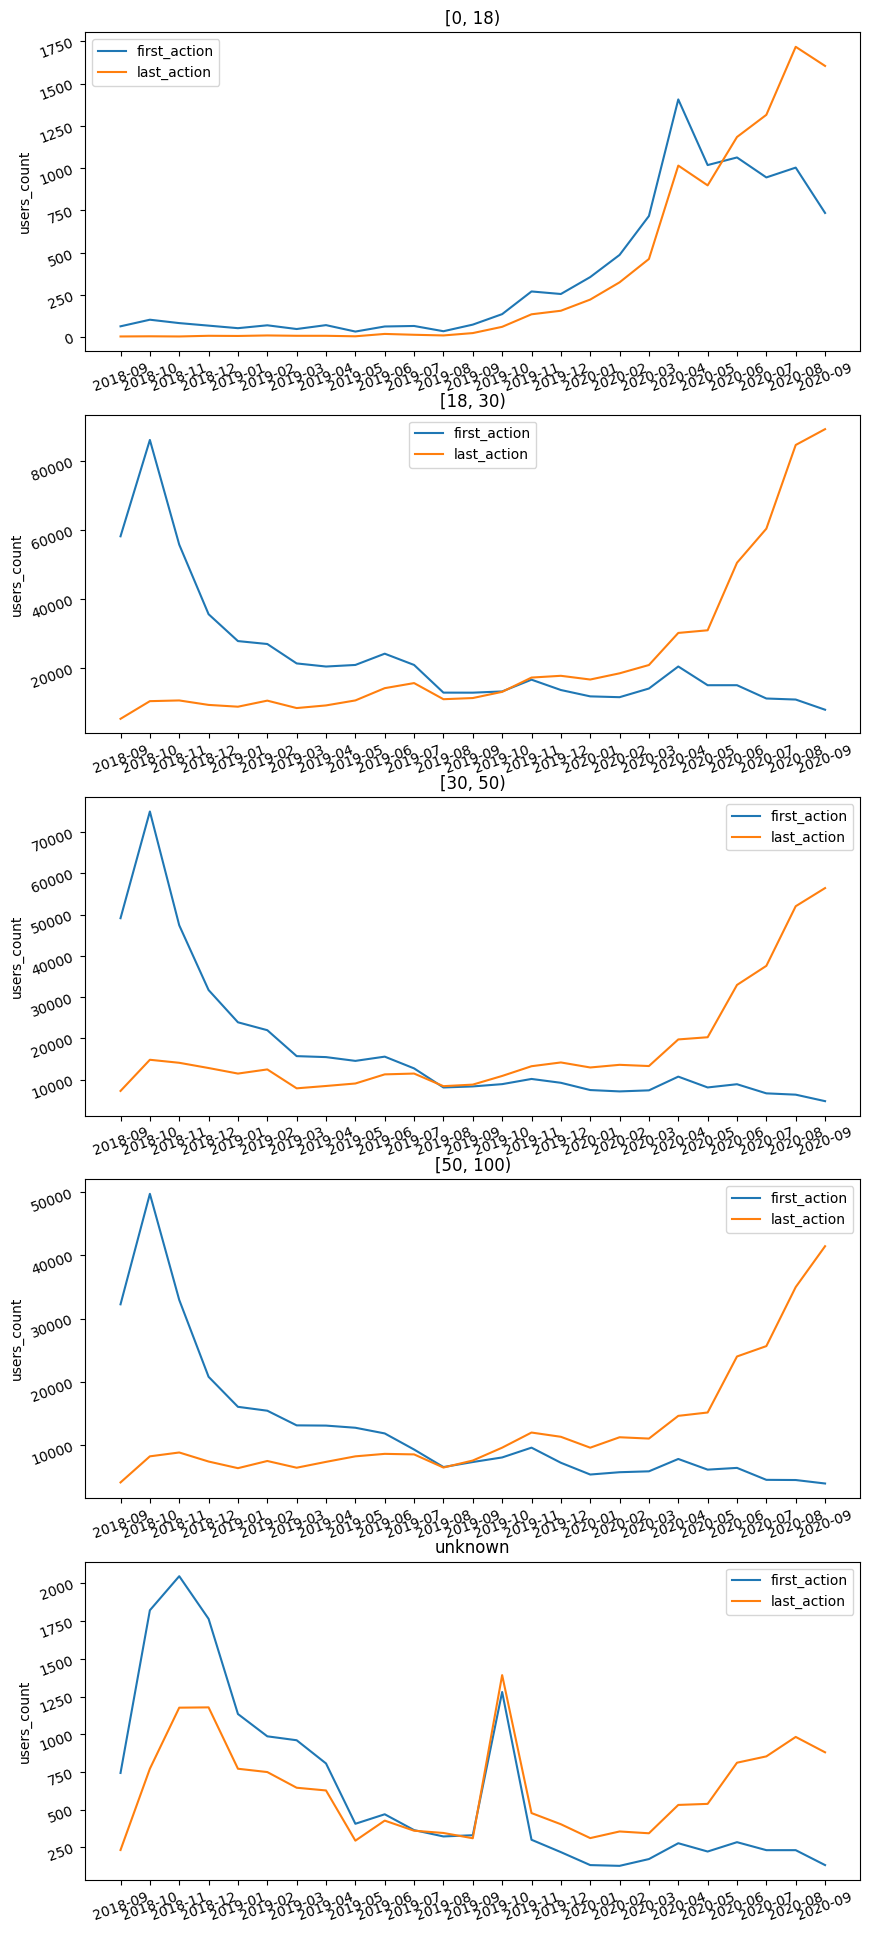

In [34]:
fig, ax = plt.subplots(paying_users.age_group.nunique(), 1, figsize=(10, 24))

for i, age_group in enumerate(sorted(paying_users.age_group.unique())):
    sns.lineplot(data=first_action[first_action.age_group == age_group], x='year_month_first_action', y='users_count', ax=ax[i], label='first_action')
    sns.lineplot(data=last_action[last_action.age_group == age_group], x='year_month_last_action', y='users_count', ax=ax[i], label='last_action')
    ax[i].tick_params(rotation=20)
    ax[i].set_title(age_group)
    ax[i].set_xlabel('')
plt.legend()

Можно увидеть, что поток несовершеннолетних пользователей начался с января 2020 года. Видимо, была запущена какая-то программа, направленная на привлечение молодой аудитории. Также можно заметить странный пик у странных юзеров. Можно было бы предположить, что это пользователи, незарегестрированные в приложении и попавшие на крупную распродажу, но пик только у неизвестных пользователей, что странно.

In [35]:
paying_users.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_group,first_purchase,last_purchase,user_purchases_count,user_total_check,year_month_first_action,year_month_last_action
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,ACTIVE,0,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,"[30, 50)",2018-12-27,2020-09-05,21,0.648983,2018-12,2020-09
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,ACTIVE,0,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,"[18, 30)",2018-09-21,2020-07-08,86,2.601932,2018-09,2020-07
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,ACTIVE,0,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"[18, 30)",2018-09-20,2020-09-15,18,0.704780,2018-09,2020-09
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,ACTIVE,0,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,"[50, 100)",2019-06-09,2019-06-09,2,0.060983,2019-06,2019-06
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,"[50, 100)",2018-10-12,2020-08-12,13,0.469695,2018-10,2020-08


In [36]:
paying_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362281 entries, 0 to 1362280
Data columns (total 14 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   customer_id              1362281 non-null  object        
 1   FN                       1362281 non-null  int64         
 2   Active                   1362281 non-null  int64         
 3   club_member_status       1362281 non-null  object        
 4   fashion_news_frequency   1362281 non-null  object        
 5   age                      1362281 non-null  int64         
 6   postal_code              1362281 non-null  object        
 7   age_group                1362281 non-null  category      
 8   first_purchase           1362281 non-null  datetime64[ns]
 9   last_purchase            1362281 non-null  datetime64[ns]
 10  user_purchases_count     1362281 non-null  int64         
 11  user_total_check         1362281 non-null  float64       
 12  

Сколько в среднем пользователи оставили денег и совершили покупок + общее количество покупок в разбивке на возрастные группы.

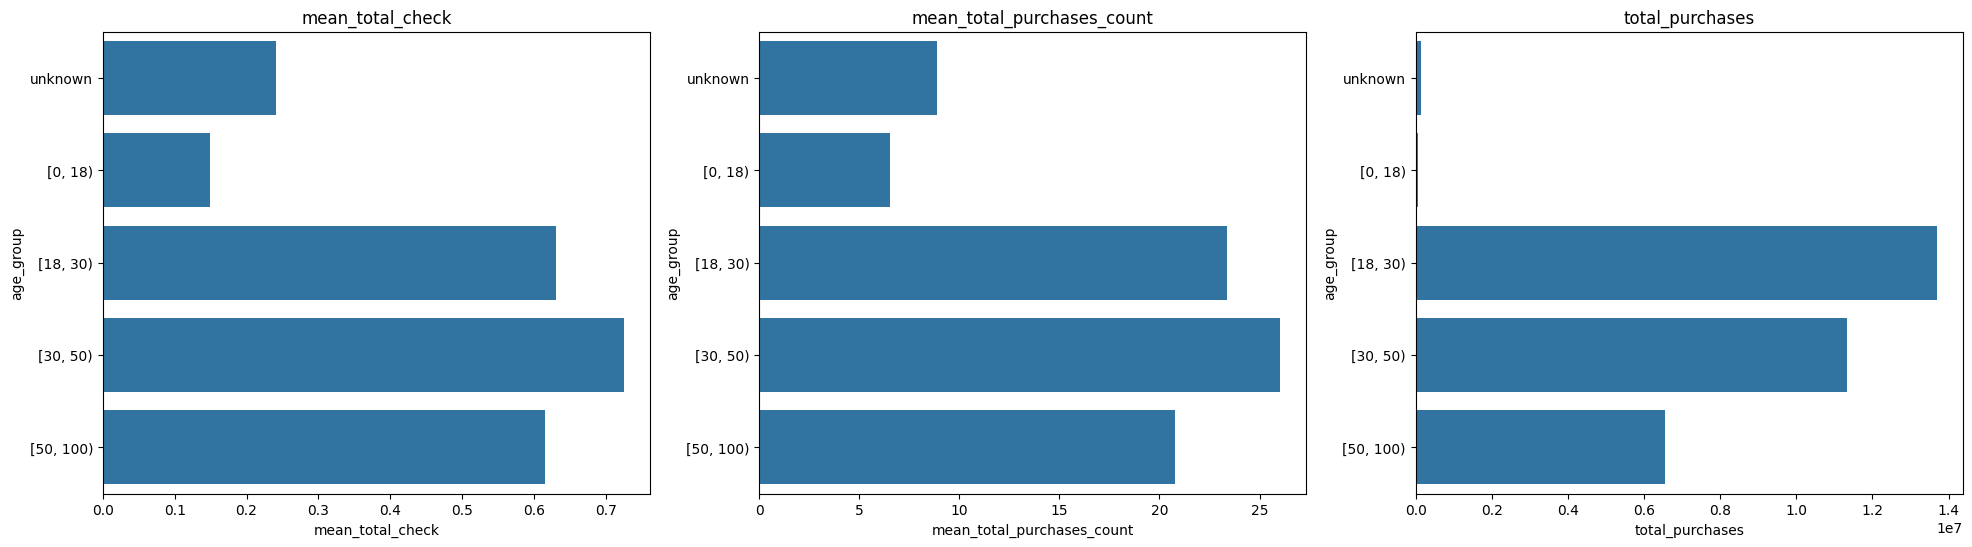

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))

tmp = paying_users \
    .groupby(['age_group'], as_index=False, observed=True) \
    .agg(
        mean_total_check=('user_total_check', pd.Series.mean), 
        mean_total_purchases_count=('user_purchases_count', pd.Series.mean),
        total_purchases =('user_purchases_count', pd.Series.sum)
    )

sns.barplot(data=tmp, x='mean_total_check', y='age_group', ax=ax[0])
ax[0].set_title('mean_total_check')
sns.barplot(data=tmp, x='mean_total_purchases_count', y='age_group', ax=ax[1])
ax[1].set_title('mean_total_purchases_count')
sns.barplot(data=tmp, x='total_purchases', y='age_group', ax=ax[2])
ax[2].set_title('total_purchases');

## Articles

In [38]:
articles = pd.read_csv(r'./data/articles.csv.zip')
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [39]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [40]:
articles.nunique()

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64

In [41]:
product_types = articles \
    .groupby(['product_type_no', 'product_type_name'], as_index=False) \
    .agg({'article_id': pd.Series.count}) 
product_types[product_types.duplicated(subset='product_type_name', keep=False)]

,product_type_no,product_type_name,article_id
22,83,Umbrella,26
129,532,Umbrella,3


In [42]:
del product_types

In [43]:
articles.drop(columns=['product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id', 'perceived_colour_master_id', 'index_code', 'index_group_no', 'garment_group_no', 'section_no', 'department_no'], inplace=True)
articles.head()

,article_id,product_code,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
0,108775015,108775,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [44]:
articles = pd.merge(articles, articles_purchases, how='left', on='article_id')
del articles_purchases

articles.head()

,article_id,product_code,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,first_purchase,last_purchase,purchases,revenue,lifetime
0,108775015,108775,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,2018-09-20,2020-07-22,10841.0,88.262881,671.0
1,108775044,108775,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,2018-09-20,2020-09-20,7250.0,58.826169,731.0
2,108775051,108775,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,2018-09-20,2019-06-28,215.0,1.070644,281.0
3,110065001,110065,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",2018-09-20,2020-08-02,1044.0,21.108746,682.0
4,110065002,110065,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",2018-09-20,2020-08-05,539.0,9.812746,685.0


In [45]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   article_id                    105542 non-null  int64         
 1   product_code                  105542 non-null  int64         
 2   prod_name                     105542 non-null  object        
 3   product_type_name             105542 non-null  object        
 4   product_group_name            105542 non-null  object        
 5   graphical_appearance_name     105542 non-null  object        
 6   colour_group_name             105542 non-null  object        
 7   perceived_colour_value_name   105542 non-null  object        
 8   perceived_colour_master_name  105542 non-null  object        
 9   department_name               105542 non-null  object        
 10  index_name                    105542 non-null  object        
 11  index_group_n

In [46]:
articles[articles.purchases.isna()].shape

(995, 20)

In [ ]:
articles.loc[articles.purchases.isna(), ['purchases', 'revenue']] = 0
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   article_id                    105542 non-null  int64         
 1   product_code                  105542 non-null  int64         
 2   prod_name                     105542 non-null  object        
 3   product_type_name             105542 non-null  object        
 4   product_group_name            105542 non-null  object        
 5   graphical_appearance_name     105542 non-null  object        
 6   colour_group_name             105542 non-null  object        
 7   perceived_colour_value_name   105542 non-null  object        
 8   perceived_colour_master_name  105542 non-null  object        
 9   department_name               105542 non-null  object        
 10  index_name                    105542 non-null  object        
 11  index_group_n

Время жизни товаров. Можно заметить, что большая часть - это товары-однодневки. Скорее всего лимитированные серии или просто непопулярные версии. Также есть некоторое кол-во товаров, отмеченных в базе, но с нулевым кол-вом покупок.

In [101]:
lifetime = articles \
    .groupby('product_code', as_index=False) \
    .agg(
        first_purchase_prod_id=('first_purchase', pd.Series.min),
        last_purchase_prod_id=('last_purchase', pd.Series.max),
        purchases=('purchases', pd.Series.sum)
    ).dropna()
lifetime['lifetime'] = (lifetime.last_purchase_prod_id - lifetime.first_purchase_prod_id).dt.days

Text(0.5, 1.0, 'articles lifetime')

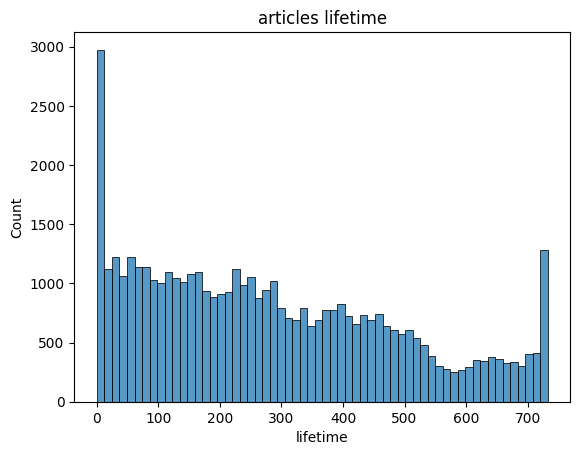

In [102]:
sns.histplot(data=lifetime, x='lifetime', bins=60)
plt.title('articles lifetime')

In [103]:
lifetime[lifetime['lifetime'] == 0].sort_values('purchases', ascending=False).head()

,product_code,first_purchase_prod_id,last_purchase_prod_id,purchases,lifetime
39687,852552,2020-03-26,2020-03-26,8.0,0
45178,903950,2020-09-22,2020-09-22,8.0,0
42041,872031,2020-03-26,2020-03-26,6.0,0
45333,905949,2020-09-22,2020-09-22,6.0,0
46569,925779,2020-09-15,2020-09-15,6.0,0


---

Идея: определить, какие категории товаров берут вместе чаще всего.

In [51]:
categories_heatmap = transactions[['customer_id', 't_dat', 'article_id']]

In [52]:
categories_heatmap = pd.merge(categories_heatmap, articles, how='left', on='article_id')
categories_heatmap = categories_heatmap[['customer_id', 't_dat', 'product_type_name']]
categories_heatmap = categories_heatmap.drop_duplicates()
categories_heatmap.head()

,customer_id,t_dat,product_type_name
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,Underwear body
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,Bra
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,Sweater
7,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,2018-09-20,Blouse
8,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,2018-09-20,Trousers


In [53]:
categories_heatmap.shape

(19980347, 3)

In [54]:
top_categories = categories_heatmap['product_type_name'] \
    .value_counts() \
    .head(15) \
    .index

categories_heatmap = categories_heatmap[categories_heatmap['product_type_name'].isin(top_categories)]
categories_heatmap.shape

(14869426, 3)

In [55]:
pair_counter = Counter()

for _, g in categories_heatmap.groupby(['customer_id', 't_dat']):
    cats = g['product_type_name'].unique()
    for c1, c2 in combinations(sorted(cats), 2):
        pair_counter[(c1, c2)] += 1

In [56]:
pair_counter

Counter({('Sweater', 'Trousers'): 498353,
         ('Bikini top', 'Swimwear bottom'): 463018,
         ('Dress', 'Trousers'): 385100,
         ('T-shirt', 'Trousers'): 366980,
         ('Top', 'Trousers'): 339971,
         ('Blouse', 'Trousers'): 312649,
         ('Sweater', 'Top'): 272217,
         ('Bra', 'Underwear bottom'): 262678,
         ('T-shirt', 'Top'): 260369,
         ('Sweater', 'T-shirt'): 255601,
         ('Dress', 'Top'): 251357,
         ('Blouse', 'Dress'): 249641,
         ('Dress', 'Sweater'): 239259,
         ('Dress', 'T-shirt'): 238578,
         ('T-shirt', 'Vest top'): 215404,
         ('Trousers', 'Vest top'): 214844,
         ('Blouse', 'Top'): 203041,
         ('Blouse', 'Sweater'): 201812,
         ('Dress', 'Vest top'): 198155,
         ('Dress', 'Skirt'): 192538,
         ('Top', 'Vest top'): 186333,
         ('Shirt', 'Trousers'): 185015,
         ('Shorts', 'T-shirt'): 171197,
         ('Blouse', 'T-shirt'): 161235,
         ('Dress', 'Shorts'): 160246,

In [57]:
categories_heatmap = pd.DataFrame(
    [(c1, c2, n) for (c1, c2), n in pair_counter.items()], 
    columns=['cat_1', 'cat_2', 'count']
)

categories_heatmap.head()

,cat_1,cat_2,count
0,Shirt,Skirt,43867
1,Dress,Sweater,239259
2,Sweater,T-shirt,255601
3,Sweater,Top,272217
4,Sweater,Vest top,132067


In [58]:
categories_heatmap = categories_heatmap.pivot(
    index='cat_1',
    columns='cat_2',
    values='count'
).fillna(0)

categories_heatmap

cat_2,Blouse,Bra,Dress,Leggings/Tights,Shirt,Shorts,Skirt,Sweater,Swimwear bottom,T-shirt,Top,Trousers,Underwear bottom,Vest top
cat_1,,,,,,,,,,,,,,
Bikini top,45368.0,56308.0,103750.0,18977.0,19058.0,71381.0,42384.0,37673.0,463018.0,66198.0,56714.0,77740.0,36251.0,72253.0
Blouse,0.0,70361.0,249641.0,46173.0,121099.0,83636.0,112993.0,201812.0,44603.0,161235.0,203041.0,312649.0,51804.0,127574.0
Bra,0.0,0.0,113767.0,85962.0,35135.0,57591.0,49379.0,116529.0,52235.0,115342.0,100400.0,147175.0,262678.0,113697.0
Dress,0.0,0.0,0.0,84758.0,98200.0,160246.0,192538.0,239259.0,101788.0,238578.0,251357.0,385100.0,84845.0,198155.0
Leggings/Tights,0.0,0.0,0.0,0.0,24254.0,32271.0,30606.0,107366.0,18564.0,112906.0,80766.0,124528.0,38028.0,83149.0
Shirt,0.0,0.0,0.0,0.0,0.0,44134.0,43867.0,126060.0,21022.0,103692.0,82998.0,185015.0,30840.0,54345.0
Shorts,0.0,0.0,0.0,0.0,0.0,0.0,70121.0,57573.0,76941.0,171197.0,103022.0,148096.0,41561.0,148699.0
Skirt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,137056.0,41614.0,117005.0,125033.0,158298.0,35372.0,100394.0
Sweater,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37617.0,255601.0,272217.0,498353.0,90940.0,132067.0


In [59]:
cats = sorted(
    set(categories_heatmap.index) | set(categories_heatmap.columns)
)

categories_heatmap = categories_heatmap.reindex(
    index=cats,
    columns=cats,
    fill_value=0
)

categories_heatmap = categories_heatmap + categories_heatmap.T
categories_heatmap

cat_2,Bikini top,Blouse,Bra,Dress,Leggings/Tights,Shirt,Shorts,Skirt,Sweater,Swimwear bottom,T-shirt,Top,Trousers,Underwear bottom,Vest top
cat_1,,,,,,,,,,,,,,,
Bikini top,0.0,45368.0,56308.0,103750.0,18977.0,19058.0,71381.0,42384.0,37673.0,463018.0,66198.0,56714.0,77740.0,36251.0,72253.0
Blouse,45368.0,0.0,70361.0,249641.0,46173.0,121099.0,83636.0,112993.0,201812.0,44603.0,161235.0,203041.0,312649.0,51804.0,127574.0
Bra,56308.0,70361.0,0.0,113767.0,85962.0,35135.0,57591.0,49379.0,116529.0,52235.0,115342.0,100400.0,147175.0,262678.0,113697.0
Dress,103750.0,249641.0,113767.0,0.0,84758.0,98200.0,160246.0,192538.0,239259.0,101788.0,238578.0,251357.0,385100.0,84845.0,198155.0
Leggings/Tights,18977.0,46173.0,85962.0,84758.0,0.0,24254.0,32271.0,30606.0,107366.0,18564.0,112906.0,80766.0,124528.0,38028.0,83149.0
Shirt,19058.0,121099.0,35135.0,98200.0,24254.0,0.0,44134.0,43867.0,126060.0,21022.0,103692.0,82998.0,185015.0,30840.0,54345.0
Shorts,71381.0,83636.0,57591.0,160246.0,32271.0,44134.0,0.0,70121.0,57573.0,76941.0,171197.0,103022.0,148096.0,41561.0,148699.0
Skirt,42384.0,112993.0,49379.0,192538.0,30606.0,43867.0,70121.0,0.0,137056.0,41614.0,117005.0,125033.0,158298.0,35372.0,100394.0
Sweater,37673.0,201812.0,116529.0,239259.0,107366.0,126060.0,57573.0,137056.0,0.0,37617.0,255601.0,272217.0,498353.0,90940.0,132067.0


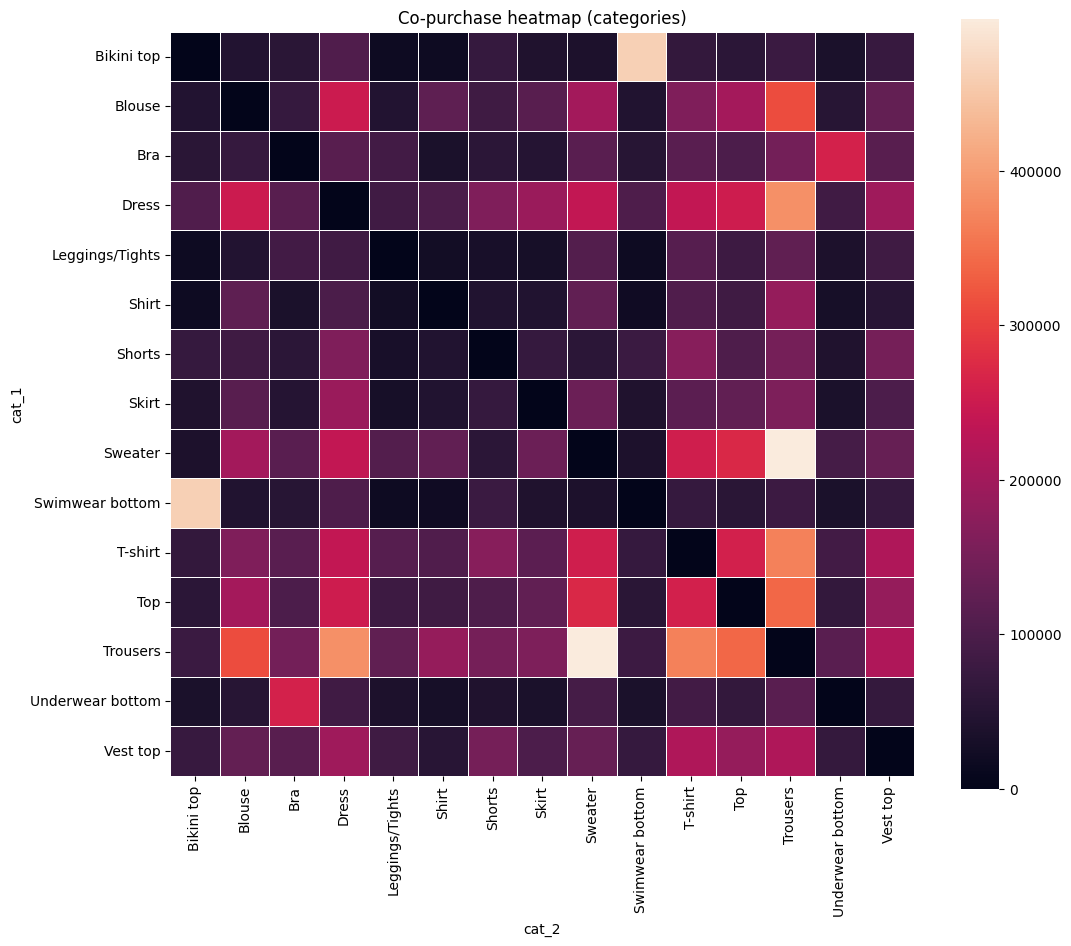

In [60]:
plt.figure(figsize=(12, 10))

sns.heatmap(
    categories_heatmap,
    linewidths=0.5,
    square=True
)

plt.title("Co-purchase heatmap (categories)");

## Энтропия интересов

Задача: определить, покупают ли пользователи разные группы товаров или берут одно и то же. Считаем энтропию (мера неопределённости выбора категории пользователем) для каждого пользователя. Чем она выше, тем разнообразнее его корзина. Если энтропия низкая, значит пользователь приходит за одним и тем же. Отберем пользователей, которые приобрели хотябы 3 товара.

In [ ]:
selected_customers = transactions.groupby('customer_id', as_index=False).size()
selected_customers = selected_customers[selected_customers['size'] >= 3].customer_id

,customer_id,size
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,21
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,86
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,18
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,13
...,...,...
1362276,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,51
1362277,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,84
1362278,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,45
1362279,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,7


In [ ]:
entropy = transactions.loc[transactions.customer_id.isin(selected_customers), ['customer_id', 'article_id']]
entropy = pd.merge(entropy, articles, how='left', on='article_id')[['customer_id', 'product_type_name']]
entropy.head()

,customer_id,product_type_name
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Underwear body
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Bra
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,Sweater
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,Sweater
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,Sweater


In [62]:
entropy.isna().sum()

customer_id          0
product_type_name    0
dtype: int64

In [63]:
entropy = entropy \
    .groupby(['customer_id', 'product_type_name'], as_index=False) \
    .size()

In [64]:
entropy.head()

,customer_id,product_type_name,size
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Blazer,5
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Dress,1
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Gloves,1
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Hoodie,1
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Jacket,3


In [65]:
entropy['p'] = entropy['size'] / entropy.groupby('customer_id', as_index=False)['size'].transform(pd.Series.sum)
entropy.head()

,customer_id,product_type_name,size,p
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Blazer,5,0.238095
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Dress,1,0.047619
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Gloves,1,0.047619
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Hoodie,1,0.047619
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Jacket,3,0.142857


In [66]:
user_entropy  = entropy \
    .assign(entropy_part=lambda x: -x['p']*np.log(x['p'])) \
    .groupby('customer_id', as_index=False) \
    .entropy_part \
    .sum()

user_entropy.head()

,customer_id,entropy_part
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2.372350
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2.597721
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2.197225
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.000000
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2.098147


In [67]:
# Нормализация
eps = 1e-6
cnt_user_categories = entropy \
    .groupby('customer_id') \
    .agg(
        n_cat=('product_type_name', pd.Series.nunique),
        n_items=('size', pd.Series.sum)
    )

user_entropy = pd.merge(user_entropy, cnt_user_categories, how='left', on='customer_id')
user_entropy['normalized_entropy'] = user_entropy.entropy_part / np.log(user_entropy['n_cat']+eps)
user_entropy.head()

,customer_id,entropy_part,n_cat,n_items,normalized_entropy
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2.372350,13,21,0.924911
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2.597721,23,86,0.828489
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2.197225,10,18,0.954242
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.000000,1,2,0.000000
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2.098147,9,13,0.954908


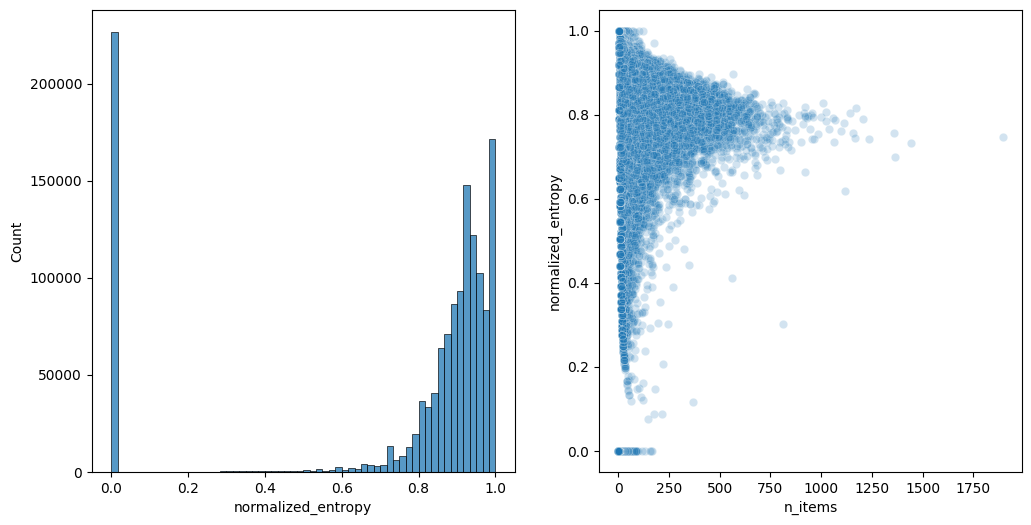

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=user_entropy,  x='normalized_entropy', bins=60, ax=ax[0])
sns.scatterplot(data=user_entropy, x='n_items', y='normalized_entropy', alpha=0.2, ax=ax[1]);

Видно, что энтропия у большинства пользователей высокая, а значит пользователи приходят за разными товарами, что логично, ведь H&M — мультикатегорийный ритейл.

In [69]:
del cnt_user_categories, entropy, user_entropy

# Гипотезы

- 1. Этропия пользователя растет со временем, т.е. в самом начале пользователи аккуратничают и стараются брать уже проверенные товары, а со временем начинают доверять бренду и начинают покупать товары из других категорий.
- 2. В онлайне и оффлайне поведение пользователей отличается. Например, средний размер корзины в оффлайне больше. 

### 1.

In [70]:
transactions['total_purchases'] = \
    transactions \
    .groupby('customer_id', as_index=False) \
    .article_id \
    .transform(pd.Series.count)

In [71]:
n = 5
entropy_transactions = transactions.loc[(transactions.total_purchases > 2*n) & (transactions.total_purchases < transactions.total_purchases.quantile(0.95)), ['customer_id', 'article_id', 't_dat']]

entropy_transactions = pd.merge(entropy_transactions, articles, how='left', on='article_id')[['customer_id', 'product_type_name', 't_dat']]

entropy_transactions.sort_values(['customer_id', 't_dat'], inplace=True)

first_n_entropy = \
    entropy_transactions \
    .groupby('customer_id', as_index=False) \
    .head(n)

last_n_entropy = \
    entropy_transactions \
    .groupby('customer_id', as_index=False) \
    .tail(n)

In [72]:
first_n_entropy = first_n_entropy \
    .groupby(['customer_id', 'product_type_name'], as_index=False) \
    .size()

last_n_entropy = last_n_entropy \
    .groupby(['customer_id', 'product_type_name'], as_index=False) \
    .size()

In [73]:
first_n_entropy['p'] = first_n_entropy['size'] / first_n_entropy.groupby('customer_id', as_index=False)['size'].transform(pd.Series.sum)
last_n_entropy['p'] = last_n_entropy['size'] / last_n_entropy.groupby('customer_id', as_index=False)['size'].transform(pd.Series.sum)

user_entropy_first  = first_n_entropy \
    .assign(entropy_part=lambda x: -x['p']*np.log(x['p'])) \
    .groupby('customer_id', as_index=False) \
    .entropy_part \
    .sum()

user_entropy_last  = last_n_entropy \
    .assign(entropy_part=lambda x: -x['p']*np.log(x['p'])) \
    .groupby('customer_id', as_index=False) \
    .entropy_part \
    .sum()

user_entropy_first.head()

,customer_id,entropy_part
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1.332179
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1.332179
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1.332179
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.609438
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,0.000000


In [74]:
# Нормализация
eps=1e-4

cnt_user_categories_first = first_n_entropy \
    .groupby('customer_id') \
    .agg(
        n_cat=('product_type_name', pd.Series.nunique)
    )

cnt_user_categories_last = last_n_entropy \
    .groupby('customer_id') \
    .agg(
        n_cat=('product_type_name', pd.Series.nunique)
    )
user_entropy_first = pd.merge(user_entropy_first, cnt_user_categories_first, how='left', on='customer_id')
user_entropy_last = pd.merge(user_entropy_last, cnt_user_categories_last, how='left', on='customer_id')

user_entropy_first['normalized_entropy'] = user_entropy_first.entropy_part / np.log(user_entropy_first['n_cat']+eps) 
user_entropy_last['normalized_entropy'] = user_entropy_last.entropy_part / np.log(user_entropy_last['n_cat']+eps)

In [75]:
user_entropy_first.normalized_entropy.mean(), user_entropy_last.normalized_entropy.mean()

(np.float64(0.8979519001379749), np.float64(0.8972323518447497))

Различия в 3 знаке после запятой. Смысла в статистических гипотезах нет.

---

### 2.

Посмотрим на распределение price в зависимости от sales_channel_id. Т.к. это ratio-метрика, то воспользуемся линеаризацией. 

In [76]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,year_month,total_purchases
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,2018-09,18
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,2018-09,18
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,2018-09,120
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,2018-09,120
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,2018-09,120


In [77]:
transactions.groupby('sales_channel_id').price.mean()

sales_channel_id
1    0.022924
2    0.029891
Name: price, dtype: float64

In [78]:
def linearization(df_a, df_b, id_column, value_column):
    df_a = df_a.groupby([id_column]).agg(revenue_sum=(value_column, 'sum'),
                                         session_count=(value_column, 'count')).reset_index()
    df_b = df_b.groupby([id_column]).agg(revenue_sum=(value_column, 'sum'),
                                         session_count=(value_column, 'count')).reset_index()
    
    alpha = df_a.revenue_sum.sum()/df_a.session_count.sum()

    df_a['L'] = df_a.revenue_sum - alpha*df_a.session_count
    df_b['L'] = df_b.revenue_sum - alpha*df_b.session_count

    p = stats.ttest_ind(df_a.L, df_b.L, equal_var=False).pvalue
    return p, df_a.L.mean()-df_b.L.mean()

linearization(
    df_a=transactions.loc[transactions.sales_channel_id==1, ['customer_id', 'price']], 
    df_b=transactions.loc[transactions.sales_channel_id==2, ['customer_id', 'price']],
    id_column='customer_id',
    value_column='price'
)

(np.float64(0.0), np.float64(-0.1406684758974702))

Получилось так, что разница линеаризованных средних статзначимо отличается, значит бъекты с sales_channel_id=2 в среднем ассоциированы с более высоким значением метрики, чем объекты sales_channel_id=1. Возможно, тут сыграли пользователи, совершившие аномально большое количество покупок. Также важно понимать, что пользователи могли быть в двух группах одновременно, что может некоторым образом исказить результат.

In [79]:
sales_by_channel = transactions \
    .groupby(['sales_channel_id', 'customer_id'], as_index=False) \
    .size()

sales_channel_id
1    12.763848
2    20.190814
Name: size, dtype: float64

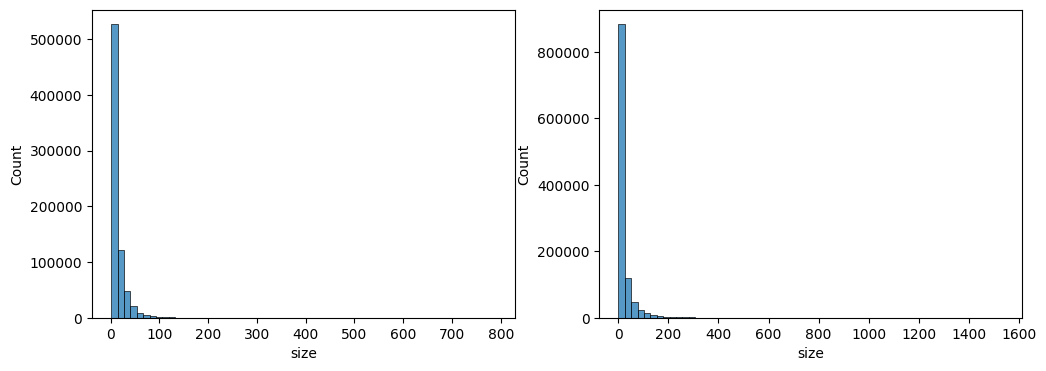

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=sales_by_channel[sales_by_channel.sales_channel_id == 1], x='size', bins=60, ax=ax[0])
sns.histplot(data=sales_by_channel[sales_by_channel.sales_channel_id == 2], x='size', bins=60, ax=ax[1])

sales_by_channel \
    .groupby('sales_channel_id') \
    ['size'] \
    .mean()

In [ ]:
# Избавимся от выбросов

sales_by_channel = sales_by_channel[sales_by_channel['size'] < sales_by_channel['size'].quantile(0.95)]

In [82]:
transactions_noutliers = transactions[transactions.customer_id.isin(sales_by_channel.customer_id)]

linearization(
    df_a=transactions_noutliers.loc[transactions_noutliers.sales_channel_id==1, ['customer_id', 'price']], 
    df_b=transactions_noutliers.loc[transactions_noutliers.sales_channel_id==2, ['customer_id', 'price']],
    id_column='customer_id',
    value_column='price'
)

(np.float64(0.0), np.float64(-0.12235242471436265))

Различия все еще статзначимы.

---

Посмотрим на распределения кол-ва покупок, сделанных пользователями внимательнее.

Воспользоваться t-test'ом нельзя из-за ассиметричных распределений. Тест Манна-Уитни тоже не подходит, т.к. будет проблема с рангами из-за одинаковых значений. Бутстрап не дождемся. Поэтому поделим пользователей на 2 категории: Кол-во купленнх товаров больше 5 и меньше, а после воспользуемся критерийем $\chi^2$ Пирсона.

sales_channel_id
1    11.462893
2    12.066800
Name: size, dtype: float64

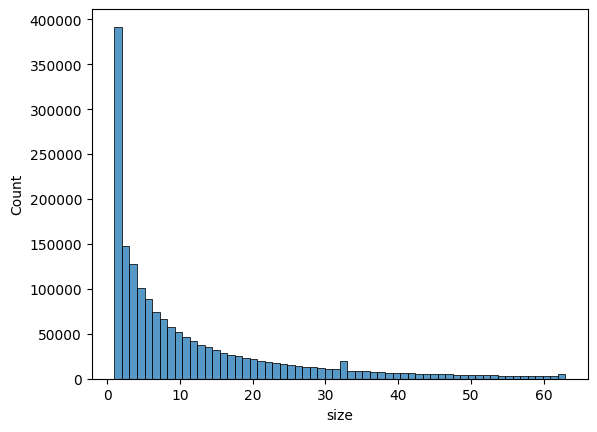

In [83]:
sns.histplot(data=sales_by_channel, x='size', bins=60)
sales_by_channel \
    .groupby('sales_channel_id') \
    ['size'] \
    .mean()

In [84]:
sales_by_channel.head()

,sales_channel_id,customer_id,size
0,1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,9
1,1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,5
2,1,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2
3,1,00007d2de826758b65a93dd24ce629ed66842531df6699...,3
4,1,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,2


In [85]:
sales_by_channel['size_geq_5'] = sales_by_channel['size'] >= 5 

In [86]:
sales_by_channel.head()

,sales_channel_id,customer_id,size,size_geq_5
0,1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,9,True
1,1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,5,True
2,1,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2,False
3,1,00007d2de826758b65a93dd24ce629ed66842531df6699...,3,False
4,1,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,2,False


In [87]:
c_ = pd.crosstab(sales_by_channel.sales_channel_id, sales_by_channel.size_geq_5)
stats.chi2_contingency(c_)

Chi2ContingencyResult(statistic=np.float64(2606.653579341959), pvalue=np.float64(0.0), dof=1, expected_freq=array([[275935.69187625, 448907.30812375],
       [390641.30812375, 635516.69187625]]))

Отсюда можно сделать вывод, что size_geq_5 зависит от sales_channel_id. И различия в выборках оказались статистически значиммыми.

In [88]:
c_

size_geq_5,False,True
sales_channel_id,,
1,259778,465065
2,406799,619359


In [89]:
sales_by_channel.groupby('sales_channel_id').size_geq_5.mean()

sales_channel_id
1    0.641608
2    0.603571
Name: size_geq_5, dtype: float64

Изучены распределения покупок по пользователям и товарам, а также различия между онлайн- и оффлайн-каналами продаж. Показано, что поведение пользователей и популярность товаров имеют сильно неравномерные распределения: большинство пользователей совершают мало покупок, а большая часть товаров покупается редко и имеет короткий жизненный цикл.

Было замечено, что большая часть пользователей не концентрируются на одной категории. 

При сравнении price между онлайн- и оффлайн-каналами была использована линеаризация ratio-метрик, что позволило корректно применять стандартные статистические тесты. Было выяснено, что пользователи с sales_channel_id=2 в среднем ассоциированы с более высоким значением метрики, чем объекты sales_channel_id=1. При этом было отмечено, что пользователи могут совершать покупки в обоих каналах, что накладывает ограничения на интерпретацию различий между группами.